### Limit order book depth calculations 

In [94]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec


from BSE import market_session

import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [95]:
# Setting file path locations 
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'


In [96]:
tape_df = pd.read_csv(prices, header=None, names=['Type', 'Time', 'Price'])
tape_df.head(5)

,Type,Time,Price
0,Trd,0.092,96
1,Trd,0.358,106
2,Trd,0.442,139
3,Trd,0.500,145
4,Trd,0.550,179


In [97]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(5)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities
0,0.000,0,,,0,,
1,0.033,0,,,1,96,1
2,0.075,0,,,2,"96, 145","1, 1"
3,0.092,0,,,1,145,1
4,0.233,0,,,2,"145, 197","1, 1"


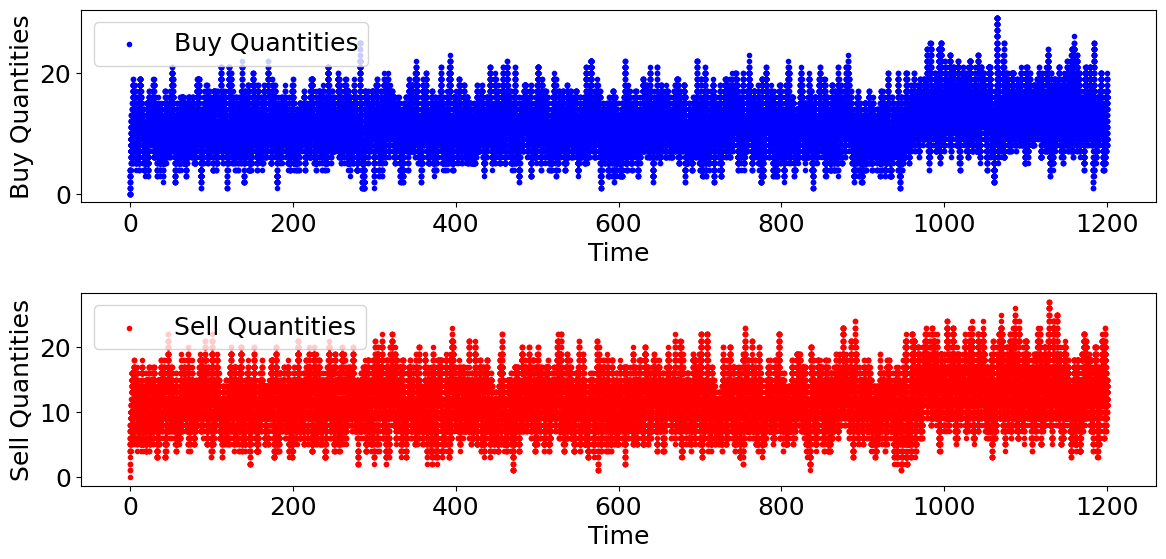

In [98]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Plot buy quantities
axs[0].scatter(time_list, bid_total_quantity, label='Buy Quantities', color='blue', marker = '.')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Buy Quantities')
axs[0].legend()
#axs[0].grid(True)

# Plot sell quantities
axs[1].scatter(time_list, ask_total_quantity, label='Sell Quantities', color='red', marker = '.')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sell Quantities')
axs[1].legend()
#axs[1].grid(True)

# Show the plots
#axs[0].set_xlim(20,120)
#axs[1].set_xlim(20,120)
#axs[0].set_ylim(50,120)
#axs[1].set_ylim(50,120)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Time')

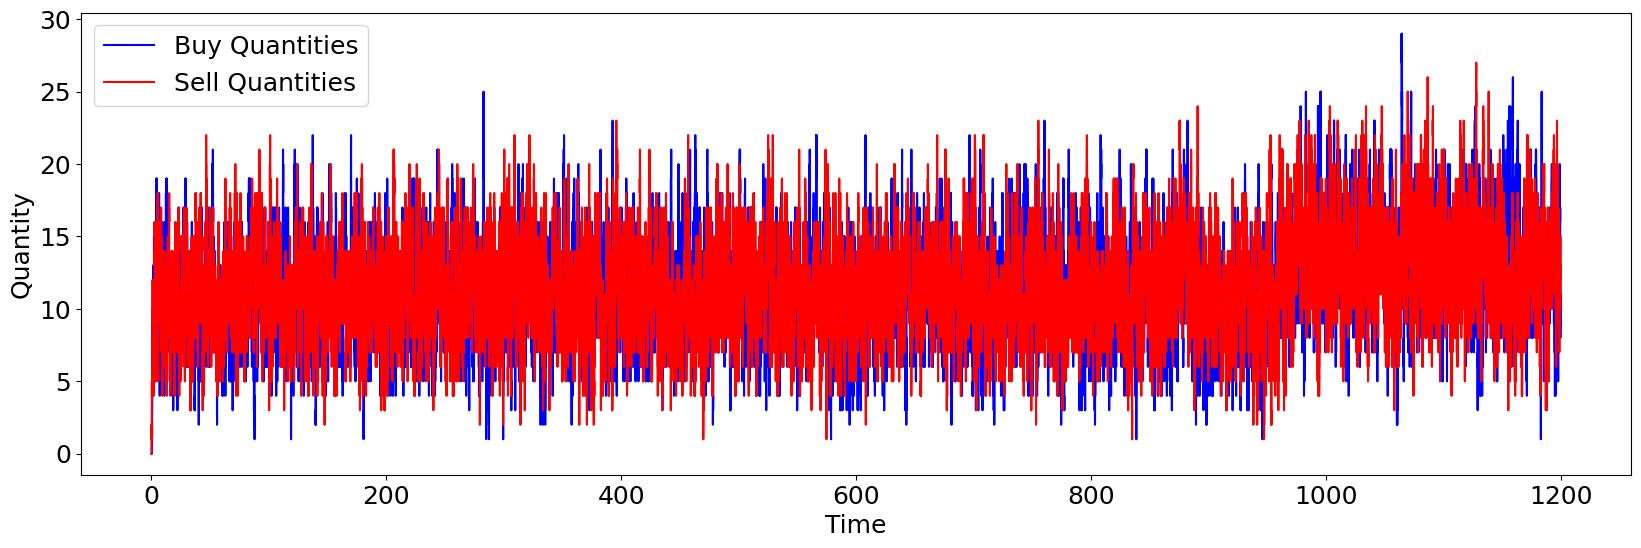

In [99]:
fig, axs = plt.subplots(figsize=(20, 6))
plt.plot(time_list, bid_total_quantity, label='Buy Quantities', color='blue')
plt.plot(time_list, ask_total_quantity, label='Sell Quantities', color='red')
plt.ylabel('Quantity')
plt.legend()
plt.xlabel('Time')

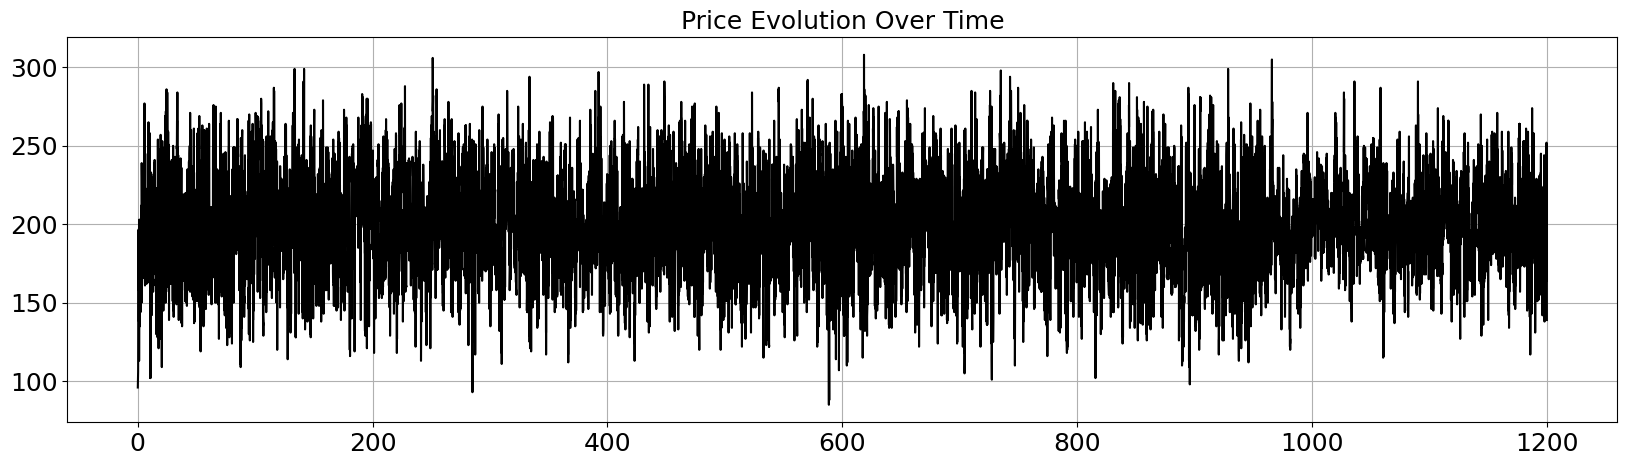

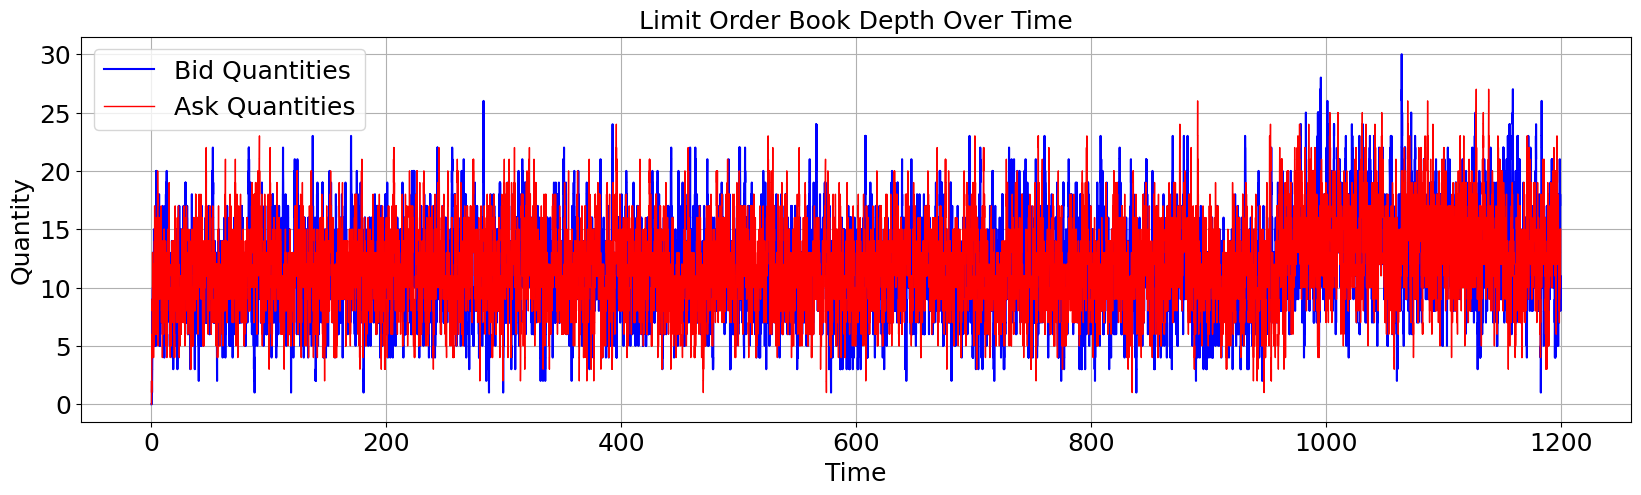

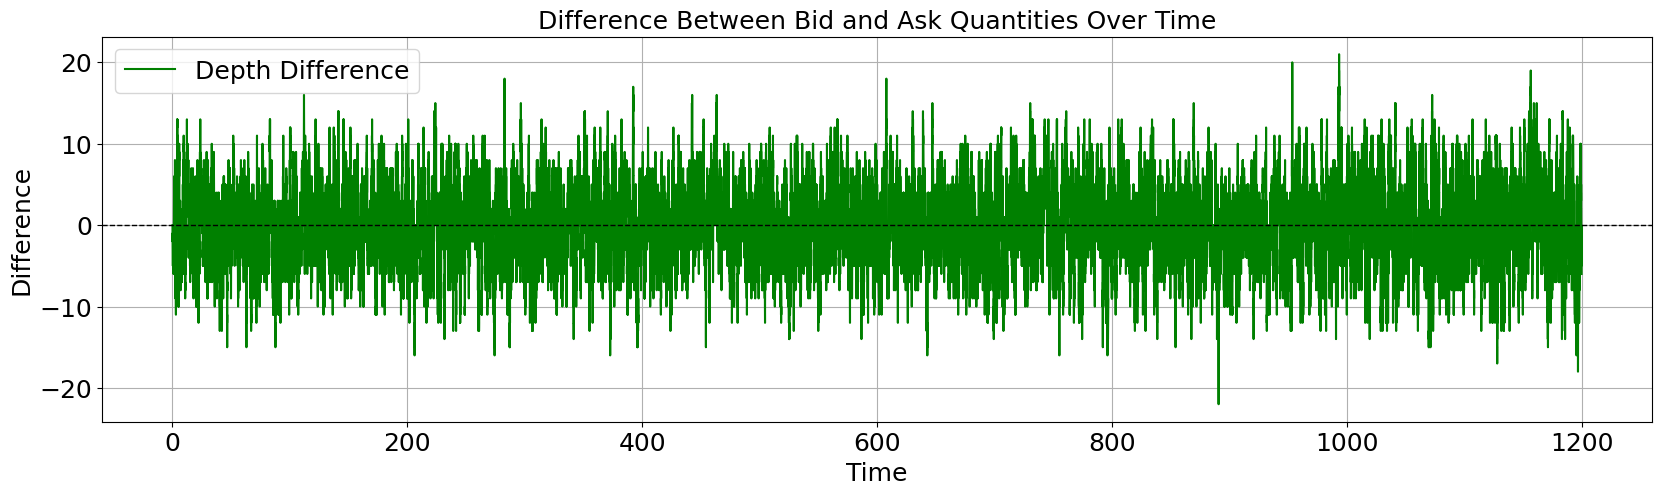

In [100]:
# Function to safely convert bid/ask quantities into lists of integers
def safe_convert_quantities(value):
    if isinstance(value, list):
        return value  # Already a list
    if isinstance(value, str):
        try:
            return [int(x) for x in value.split(',') if x.strip().isdigit()]
        except ValueError:
            return []
    return []

# Apply the safe conversion to the Bid and Ask Quantities columns
expanded_df["Bid Quantities"] = expanded_df["Bid Quantities"].apply(safe_convert_quantities)
expanded_df["Ask Quantities"] = expanded_df["Ask Quantities"].apply(safe_convert_quantities)

# Compute Bid and Ask Depth
expanded_df["Bid Depth"] = expanded_df["Bid Quantities"].apply(sum)
expanded_df["Ask Depth"] = expanded_df["Ask Quantities"].apply(sum)

#PLot the price evolution 
plt.figure(figsize=(20, 5))
plt.plot(tape_df['Time'], tape_df['Price'], label='Price', color='black')
plt.grid(True)
plt.title('Price Evolution Over Time')

# Plot the Bid and Ask Depth over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Bid Depth"], marker="none", linestyle="-", label="Bid Quantities", color = 'blue')
plt.plot(expanded_df["Time"], expanded_df["Ask Depth"], marker="none", linestyle="-", label="Ask Quantities", color = 'red', markersize=3, linewidth=1)
plt.xlabel("Time")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.title("Limit Order Book Depth Over Time")
# Calculate the difference between Bid Depth and Ask Depth
expanded_df["Depth Difference"] = expanded_df["Bid Depth"] - expanded_df["Ask Depth"]

# Plot the Depth Difference over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Depth Difference"], marker="none", linestyle="-", label="Depth Difference", color='green')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline at y=0
plt.xlabel("Time")
plt.ylabel("Difference")
plt.title("Difference Between Bid and Ask Quantities Over Time")
plt.legend()
plt.grid()
plt.show()



In [101]:
def get_last_number(value):
    # If 'value' is a string like "110, 118", split on commas
    if isinstance(value, str):
        parts = value.split(',')
        # Strip whitespace from each part
        parts = [p.strip() for p in parts]
        # Convert the last part to an integer
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

def get_last_number(value):
    # If 'value' is a string like "110, 118", split on commas
    if isinstance(value, str):
        parts = value.split(',')
        # Strip whitespace from each part
        parts = [p.strip() for p in parts]
        # Convert the last part to an integer
        try:
            return int(parts[0])
        except ValueError:
            return None
    return None

# Create a new column with the last number
expanded_df["Best Bid Price"] = expanded_df["Bid Prices"].apply(get_last_number)
expanded_df["Best Ask Price"] = expanded_df["Ask Prices"].apply(get_last_number)
expanded_df.head(5)

,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,Best Bid Price,Best Ask Price
0,0.000,0,,[],0,,[],0,0,0,NaN,NaN
1,0.033,0,,[],1,96,[1],0,1,-1,NaN,96.0
2,0.075,0,,[],2,"96, 145","[1, 1]",0,2,-2,NaN,96.0
3,0.092,0,,[],1,145,[1],0,1,-1,NaN,145.0
4,0.233,0,,[],2,"145, 197","[1, 1]",0,2,-2,NaN,145.0


Text(0, 0.5, 'Order Flow Imbalance')

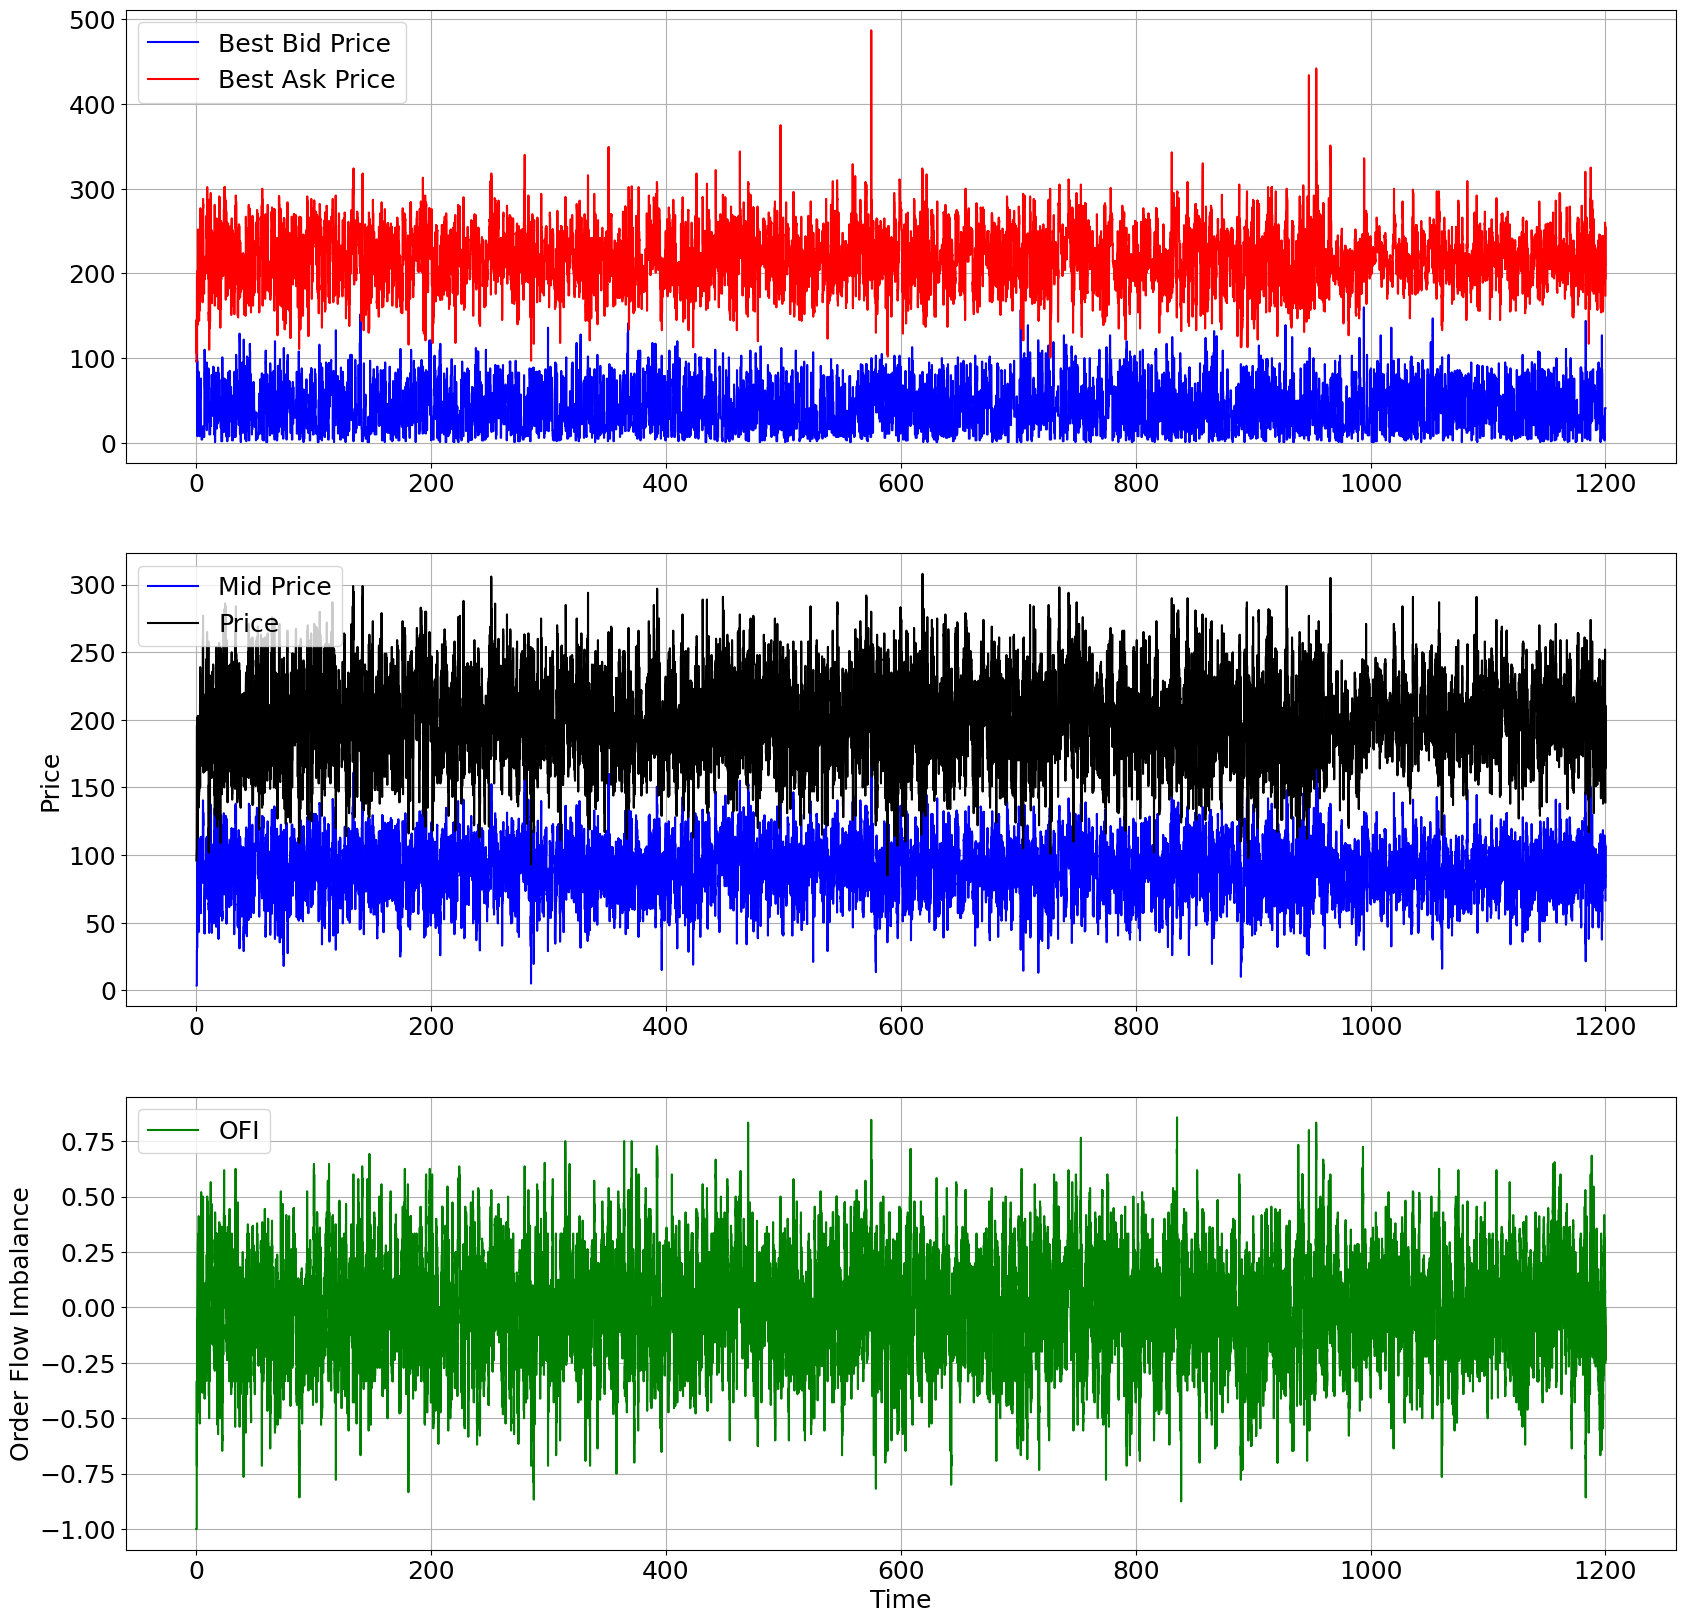

In [102]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axs[0].plot(expanded_df["Time"], expanded_df["Best Bid Price"], label="Best Bid Price", color='blue')
axs[0].plot(expanded_df["Time"], expanded_df["Best Ask Price"], label="Best Ask Price", color='red')
axs[0].legend(loc = 'upper left')
axs[0].grid(True)

axs[1].plot(expanded_df["Time"], (expanded_df["Best Ask Price"] - expanded_df['Best Bid Price'])/2, color='blue', label='Mid Price')
axs[1].plot(tape_df['Time'], tape_df['Price'], color='black' , label='Price')
axs[1].legend(loc = 'upper left')
axs[1].set_ylabel('Price')
axs[1].grid(True)

axs[2].plot(expanded_df["Time"], expanded_df["Depth Difference"]/(expanded_df['Bid Depth'] + expanded_df['Ask Depth']), color='green', label='OFI')
axs[2].legend(loc = 'upper left')
axs[2].grid(True)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Order Flow Imbalance')

Correlation test on price and mid price

In [103]:
'''
import numpy as np
import matplotlib.pyplot as plt

# Compute mid price as the average of best bid and best ask
mid_price = (expanded_df["Best Bid Price"] + expanded_df["Best Ask Price"]) / 2

# Align your price series with mid_price; here we assume they are pandas Series with the same index:
price = tape_df['Price']

# Define a range of lags (e.g., from -50 to +50 time steps)
lags = range(-50, 51)
correlations = []

for lag in lags:
    if lag < 0:
        # Negative lag: shift mid_price forward relative to price
        shifted = mid_price.shift(-lag)
        common_index = shifted.dropna().index.intersection(price.index)
        corr = np.corrcoef(shifted.loc[common_index], price.loc[common_index])[0, 1]
    elif lag > 0:
        # Positive lag: shift mid_price backward relative to price
        shifted = mid_price.shift(-lag)
        common_index = shifted.dropna().index.intersection(price.index)
        corr = np.corrcoef(shifted.loc[common_index], price.loc[common_index])[0, 1]
    else:
        common_index = mid_price.index.intersection(price.index)
        corr = np.corrcoef(mid_price.loc[common_index], price.loc[common_index])[0, 1]
    correlations.append(corr)

plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, marker='o')
plt.xlabel('Lag (time steps)')
plt.ylabel('Correlation coefficient')
plt.title('Lag Correlation between Mid Price and Price')
plt.grid(True)
plt.show()
'''

'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Compute mid price as the average of best bid and best ask\nmid_price = (expanded_df["Best Bid Price"] + expanded_df["Best Ask Price"]) / 2\n\n# Align your price series with mid_price; here we assume they are pandas Series with the same index:\nprice = tape_df[\'Price\']\n\n# Define a range of lags (e.g., from -50 to +50 time steps)\nlags = range(-50, 51)\ncorrelations = []\n\nfor lag in lags:\n    if lag < 0:\n        # Negative lag: shift mid_price forward relative to price\n        shifted = mid_price.shift(-lag)\n        common_index = shifted.dropna().index.intersection(price.index)\n        corr = np.corrcoef(shifted.loc[common_index], price.loc[common_index])[0, 1]\n    elif lag > 0:\n        # Positive lag: shift mid_price backward relative to price\n        shifted = mid_price.shift(-lag)\n        common_index = shifted.dropna().index.intersection(price.index)\n        corr = np.corrcoef(shifted.loc[common_index], pric

In [104]:
'''
# First, sort both DataFrames by Time (if not already sorted)
expanded_df = expanded_df.sort_values("Time")
tape_df = tape_df.sort_values("Time")

# Merge the DataFrames on the "Time" column, matching nearest times
df_merged = pd.merge_asof(expanded_df, tape_df, on="Time", direction="nearest")

# Compute mid price and difference
df_merged["Mid Price"] = (df_merged["Best Bid Price"] + df_merged["Best Ask Price"]) / 2
df_merged["Diff"] = df_merged["Price"] - df_merged["Mid Price"]

# Plot the difference versus time
plt.figure(figsize=(10, 6))
plt.plot(df_merged["Time"], df_merged["Diff"], marker='o')
plt.xlabel('Time')
plt.ylabel('Price - Mid Price')
plt.title('Difference between Price and Mid Price over Time')
plt.grid(True)
plt.show()
'''

'\n# First, sort both DataFrames by Time (if not already sorted)\nexpanded_df = expanded_df.sort_values("Time")\ntape_df = tape_df.sort_values("Time")\n\n# Merge the DataFrames on the "Time" column, matching nearest times\ndf_merged = pd.merge_asof(expanded_df, tape_df, on="Time", direction="nearest")\n\n# Compute mid price and difference\ndf_merged["Mid Price"] = (df_merged["Best Bid Price"] + df_merged["Best Ask Price"]) / 2\ndf_merged["Diff"] = df_merged["Price"] - df_merged["Mid Price"]\n\n# Plot the difference versus time\nplt.figure(figsize=(10, 6))\nplt.plot(df_merged["Time"], df_merged["Diff"], marker=\'o\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'Price - Mid Price\')\nplt.title(\'Difference between Price and Mid Price over Time\')\nplt.grid(True)\nplt.show()\n'

In [105]:
'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure both DataFrames are sorted by Time
expanded_df = expanded_df.sort_values("Time")
tape_df = tape_df.sort_values("Time")

# Merge the two DataFrames on the "Time" column using merge_asof to align the nearest timestamps
df_merged = pd.merge_asof(expanded_df, tape_df, on="Time", direction="nearest")

# Compute mid price
df_merged["Mid Price"] = (df_merged["Best Bid Price"] + df_merged["Best Ask Price"]) / 2

# Define a range of lags (in terms of number of observations)
lags = range(-10, 11)  # from -10 to +10
colors = plt.cm.viridis(np.linspace(0, 1, len(lags)))

plt.figure(figsize=(12, 6))

for i, lag in enumerate(lags):
    if lag < 0:
        # Negative lag: shift the Price series forward so that Price leads
        diff = df_merged["Price"].shift(-lag) - df_merged["Mid Price"]
    else:
        # Positive lag: shift the Mid Price series forward so that Price lags
        diff = df_merged["Price"] - df_merged["Mid Price"].shift(lag)
    
    # Remove NaN values created by shifting
    diff = diff.dropna()
    # Get corresponding time stamps (using the index from diff)
    times = df_merged["Time"].iloc[diff.index]
    
    plt.plot(times, diff, marker='o', linestyle='none', color=colors[i], label=f"Lag {lag}")

plt.xlabel("Time")
plt.ylabel("Price - Mid Price")
plt.title("Difference between Price and Mid Price at Various Lags")
plt.grid(True)
#plt.xlim(0, 100)
plt.show()
'''

'\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Ensure both DataFrames are sorted by Time\nexpanded_df = expanded_df.sort_values("Time")\ntape_df = tape_df.sort_values("Time")\n\n# Merge the two DataFrames on the "Time" column using merge_asof to align the nearest timestamps\ndf_merged = pd.merge_asof(expanded_df, tape_df, on="Time", direction="nearest")\n\n# Compute mid price\ndf_merged["Mid Price"] = (df_merged["Best Bid Price"] + df_merged["Best Ask Price"]) / 2\n\n# Define a range of lags (in terms of number of observations)\nlags = range(-10, 11)  # from -10 to +10\ncolors = plt.cm.viridis(np.linspace(0, 1, len(lags)))\n\nplt.figure(figsize=(12, 6))\n\nfor i, lag in enumerate(lags):\n    if lag < 0:\n        # Negative lag: shift the Price series forward so that Price leads\n        diff = df_merged["Price"].shift(-lag) - df_merged["Mid Price"]\n    else:\n        # Positive lag: shift the Mid Price series forward so that Price lags\n        diff =

In [106]:
'''
# Ensure both DataFrames are sorted by time
expanded_df = expanded_df.sort_values("Time")
tape_df = tape_df.sort_values("Time")

# Merge the two DataFrames on "Time" using merge_asof (to align nearest timestamps)
df_merged = pd.merge_asof(expanded_df, tape_df, on="Time", direction="nearest")

# Compute the mid price
df_merged["Mid Price"] = (df_merged["Best Bid Price"] + df_merged["Best Ask Price"]) / 2

# Define the range of lags (in number of observations)
lags = range(-17, 24)
correlations = []

for lag in lags:
    if lag < 0:
        # For negative lag, shift the Price series forward so that Price leads Mid Price
        shifted_price = df_merged["Price"].shift(-lag)
        common_idx = shifted_price.dropna().index.intersection(df_merged["Mid Price"].dropna().index)
        corr = np.corrcoef(shifted_price.loc[common_idx], df_merged["Mid Price"].loc[common_idx])[0, 1]
    else:
        # For positive lag, shift the Mid Price series forward so that Price lags behind
        shifted_mid = df_merged["Mid Price"].shift(lag)
        common_idx = shifted_mid.dropna().index.intersection(df_merged["Price"].dropna().index)
        corr = np.corrcoef(df_merged["Price"].loc[common_idx], shifted_mid.loc[common_idx])[0, 1]
    correlations.append(corr)

shifted_lags = [lag - 5 for lag in lags]
import numpy as np

# Find the index of the peak correlation
peak_index = np.argmax(correlations)
# Get the corresponding lag from shifted_lags
peak_lag = shifted_lags[peak_index]

plt.figure(figsize=(20, 6))
plt.axvline(0, color='black', linestyle='--')  # Line at lag=0
plt.plot(shifted_lags, correlations, marker="None", linestyle='-')

# Plot a vertical line at the peak
plt.axvline(peak_lag, color='red', linestyle='--', linewidth=2, label='Peak Correlation')
plt.xlabel("Lag (# observations)")
plt.ylabel("Correlation Coefficient")
plt.grid(False)
plt.legend()



plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', length=10, width=2, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=6, width=1,
                    top=True, bottom=True, left=True, right=True)


ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_linewidth(1.5)  # Set each spine's width to 2.5


        


plt.show()
'''

'\n# Ensure both DataFrames are sorted by time\nexpanded_df = expanded_df.sort_values("Time")\ntape_df = tape_df.sort_values("Time")\n\n# Merge the two DataFrames on "Time" using merge_asof (to align nearest timestamps)\ndf_merged = pd.merge_asof(expanded_df, tape_df, on="Time", direction="nearest")\n\n# Compute the mid price\ndf_merged["Mid Price"] = (df_merged["Best Bid Price"] + df_merged["Best Ask Price"]) / 2\n\n# Define the range of lags (in number of observations)\nlags = range(-17, 24)\ncorrelations = []\n\nfor lag in lags:\n    if lag < 0:\n        # For negative lag, shift the Price series forward so that Price leads Mid Price\n        shifted_price = df_merged["Price"].shift(-lag)\n        common_idx = shifted_price.dropna().index.intersection(df_merged["Mid Price"].dropna().index)\n        corr = np.corrcoef(shifted_price.loc[common_idx], df_merged["Mid Price"].loc[common_idx])[0, 1]\n    else:\n        # For positive lag, shift the Mid Price series forward so that Price la

---

In [107]:

# 2. Create columns for pair plotting (if not already in your DataFrame)
expanded_df["Mid Price"] = (expanded_df["Best Ask Price"] + expanded_df["Best Bid Price"]) / 2
expanded_df["OFI"] = (expanded_df["Bid Depth"] - expanded_df["Ask Depth"]) / (expanded_df["Bid Depth"] + expanded_df["Ask Depth"])
'''
# 3. Build a pairplot with Seaborn
#    Choose which columns to visualize
cols_for_pairplot = ["Best Bid Price", "Best Ask Price", "Mid Price", "OFI"]

# Optionally rename them for clarity in the plot
plot_df = expanded_df[cols_for_pairplot].rename(columns={
    "Best Bid Price": "BestBid",
    "Best Ask Price": "BestAsk",
    "Mid Price": "MidPrice"
})

# 4. Create the pairplot
sns.pairplot(plot_df, diag_kind="hist")
plt.show()
'''

'\n# 3. Build a pairplot with Seaborn\n#    Choose which columns to visualize\ncols_for_pairplot = ["Best Bid Price", "Best Ask Price", "Mid Price", "OFI"]\n\n# Optionally rename them for clarity in the plot\nplot_df = expanded_df[cols_for_pairplot].rename(columns={\n    "Best Bid Price": "BestBid",\n    "Best Ask Price": "BestAsk",\n    "Mid Price": "MidPrice"\n})\n\n# 4. Create the pairplot\nsns.pairplot(plot_df, diag_kind="hist")\nplt.show()\n'

Correlation (Mid Price(t) vs. Future Return(t+-3)): -0.24273580564743158
                            OLS Regression Results                            
Dep. Variable:          Return_future   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7971.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:25:49   Log-Likelihood:             1.4066e+05
No. Observations:              127320   AIC:                        -2.813e+05
Df Residuals:                  127318   BIC:                        -2.813e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

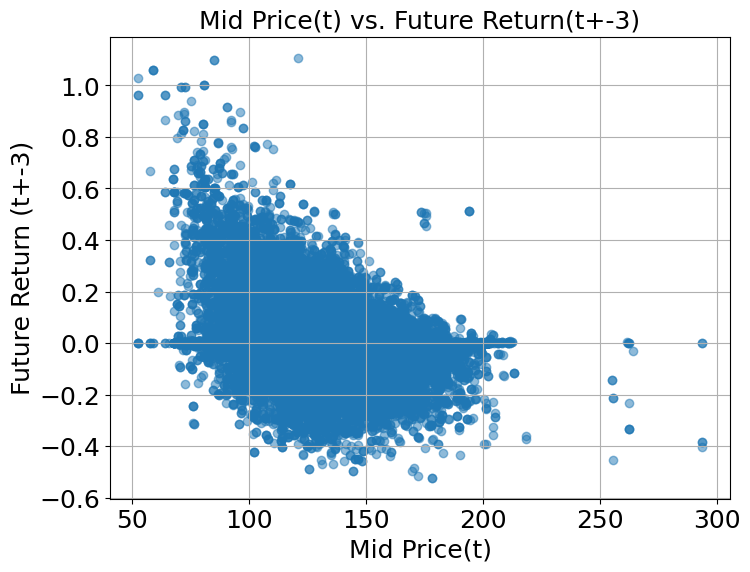

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Example: shift_steps defines how far ahead you look (e.g., 1 time-step into the future)
shift_steps = -3

# 1) Create a "future" mid price
expanded_df["MidPrice_future"] = expanded_df["Mid Price"].shift(-shift_steps)

# 2) Compute a future return (e.g., from t to t+shift_steps)
expanded_df["Return_future"] = (
    expanded_df["MidPrice_future"] - expanded_df["Mid Price"]
) / expanded_df["Mid Price"]

# 3) Drop any rows with NaNs created by shifting
expanded_df.dropna(inplace=True)

# 4) Correlation: Mid Price (now) vs. Future Return
corr_value = expanded_df["Mid Price"].corr(expanded_df["Return_future"])
print("Correlation (Mid Price(t) vs. Future Return(t+{})):".format(shift_steps), corr_value)

# 5) Simple linear regression: Return_future ~ MidPrice
X = sm.add_constant(expanded_df["Mid Price"])  # add intercept
y = expanded_df["Return_future"]
model = sm.OLS(y, X).fit()
print(model.summary())

# 6) Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(expanded_df["Mid Price"], expanded_df["Return_future"], alpha=0.5)
plt.xlabel("Mid Price(t)")
plt.ylabel("Future Return (t+{})".format(shift_steps))
plt.title("Mid Price(t) vs. Future Return(t+{})".format(shift_steps))
plt.grid(True)
plt.show()


Correlation (OFI vs. future return): -0.024687452731010695
                            OLS Regression Results                            
Dep. Variable:          Return_future   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     77.64
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           1.25e-18
Time:                        13:25:49   Log-Likelihood:             1.6242e+05
No. Observations:              127318   AIC:                        -3.248e+05
Df Residuals:                  127316   BIC:                        -3.248e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

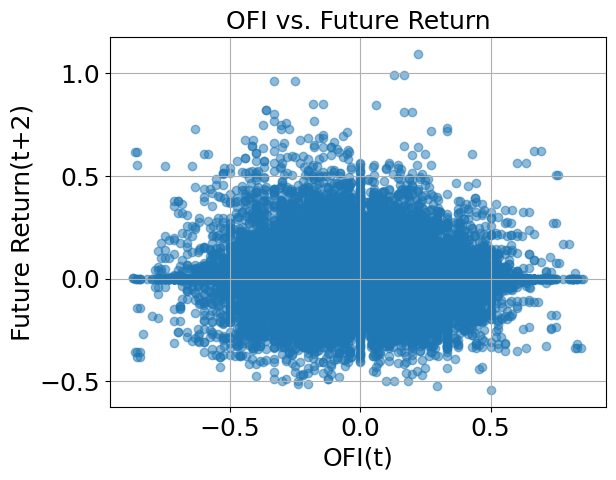

In [109]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assume df has columns: Time, MidPrice, OFI

shift_steps = 2  # define your time horizon
expanded_df["MidPrice_future"] = expanded_df["Mid Price"].shift(-shift_steps)
expanded_df["Return_future"] = (expanded_df["MidPrice_future"] - expanded_df["Mid Price"]) / expanded_df["Mid Price"]

expanded_df.dropna(inplace=True)

# Correlation
corr_value = expanded_df["OFI"].corr(expanded_df["Return_future"])
print("Correlation (OFI vs. future return):", corr_value)

# Simple linear regression
X = sm.add_constant(expanded_df["OFI"])  # add intercept
y = expanded_df["Return_future"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Scatter plot
plt.scatter(expanded_df["OFI"], expanded_df["Return_future"], alpha=0.5)
plt.xlabel("OFI(t)")
plt.ylabel("Future Return(t+{})".format(shift_steps))
plt.title("OFI vs. Future Return")
plt.grid(True)
plt.show()


In [110]:

'''

import pandas as pd

# 1. Sort both DataFrames by time
expanded_df.sort_values("Time", inplace=True)
tape_df.sort_values("Time", inplace=True)

merged_df = pd.merge(
    expanded_df,
    tape_df[["Time", "Price"]],  # only bring over the Time and Price columns
    on="Time",
    how="left"
)


# Now merged_df has columns from both expanded_df and tape_df
# including "Price" from tape_df and "Best Bid Price", "Best Ask Price", etc. from expanded_df.

# 3. Create your pairplot columns
cols_for_pairplot = [
    "Best Bid Price",
    "Best Ask Price",
    "Mid Price",
    "OFI",
    "Price"  # from tape_df
]

plot_df = merged_df[cols_for_pairplot]
sns.pairplot(plot_df)

plt.show()'
''
'''

'\n\nimport pandas as pd\n\n# 1. Sort both DataFrames by time\nexpanded_df.sort_values("Time", inplace=True)\ntape_df.sort_values("Time", inplace=True)\n\nmerged_df = pd.merge(\n    expanded_df,\n    tape_df[["Time", "Price"]],  # only bring over the Time and Price columns\n    on="Time",\n    how="left"\n)\n\n\n# Now merged_df has columns from both expanded_df and tape_df\n# including "Price" from tape_df and "Best Bid Price", "Best Ask Price", etc. from expanded_df.\n\n# 3. Create your pairplot columns\ncols_for_pairplot = [\n    "Best Bid Price",\n    "Best Ask Price",\n    "Mid Price",\n    "OFI",\n    "Price"  # from tape_df\n]\n\nplot_df = merged_df[cols_for_pairplot]\nsns.pairplot(plot_df)\n\nplt.show()\'\n\'\'\n'

In [111]:
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Sort both DataFrames by time
expanded_df.sort_values("Time", inplace=True)
tape_df.sort_values("Time", inplace=True)

# 2. Merge the DataFrames on the "Time" column (using a left join)
merged_df = pd.merge(
    expanded_df,
    tape_df[["Time", "Price"]],  # only bring over Time and Price from tape_df
    on="Time",
    how="left"
)

# 3. Select the columns for the pair plot
cols_for_pairplot = [
    "Best Bid Price",
    "Best Ask Price",
    "Mid Price",
    "OFI",
    "Price"  # from tape_df
]

plot_df = merged_df[cols_for_pairplot]

# 4. Create a PairGrid with KDE plots on off-diagonals (appearing as heat maps)
g = sns.PairGrid(plot_df, diag_sharey=False)
g.map_lower(sns.kdeplot, fill=True, cmap="Blues")
g.map_upper(sns.kdeplot, fill=True, cmap="Reds")
g.map_diag(sns.histplot, kde=True)

plt.tight_layout()
plt.grid()
plt.show()
'''

'\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# 1. Sort both DataFrames by time\nexpanded_df.sort_values("Time", inplace=True)\ntape_df.sort_values("Time", inplace=True)\n\n# 2. Merge the DataFrames on the "Time" column (using a left join)\nmerged_df = pd.merge(\n    expanded_df,\n    tape_df[["Time", "Price"]],  # only bring over Time and Price from tape_df\n    on="Time",\n    how="left"\n)\n\n# 3. Select the columns for the pair plot\ncols_for_pairplot = [\n    "Best Bid Price",\n    "Best Ask Price",\n    "Mid Price",\n    "OFI",\n    "Price"  # from tape_df\n]\n\nplot_df = merged_df[cols_for_pairplot]\n\n# 4. Create a PairGrid with KDE plots on off-diagonals (appearing as heat maps)\ng = sns.PairGrid(plot_df, diag_sharey=False)\ng.map_lower(sns.kdeplot, fill=True, cmap="Blues")\ng.map_upper(sns.kdeplot, fill=True, cmap="Reds")\ng.map_diag(sns.histplot, kde=True)\n\nplt.tight_layout()\nplt.grid()\nplt.show()\n'

In [112]:
'''

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Sort both DataFrames by time
expanded_df.sort_values("Time", inplace=True)
tape_df.sort_values("Time", inplace=True)

# 2. Merge the DataFrames on the "Time" column (using a left join)
merged_df = pd.merge(
    expanded_df,
    tape_df[["Time", "Price"]],  # only bring over Time and Price
    on="Time",
    how="left"
)

# 3. Columns for the pair plot
cols_for_pairplot = [
    "Best Bid Price",
    "Best Ask Price",
    "Mid Price",
    "OFI",
    "Price"  # from tape_df
]

plot_df = merged_df[cols_for_pairplot]

# 4. Create a PairGrid
#    - 'height' sets the height of each subplot
#    - 'aspect' sets the width-to-height ratio
g = sns.PairGrid(plot_df, diag_sharey=False, height=2.5, aspect=1.0)

# Map the plots
g.map_lower(sns.kdeplot, fill=True, cmap="Blues")
g.map_upper(sns.kdeplot, fill=True, cmap="Reds")
g.map_diag(sns.histplot, kde=True)

# Make subplots closer:
#  - 'hspace' is the vertical space between plots
#  - 'wspace' is the horizontal space between plots
g.fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Optionally also use a tighter layout
g.fig.tight_layout()

plt.show()
'''

'\n\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# 1. Sort both DataFrames by time\nexpanded_df.sort_values("Time", inplace=True)\ntape_df.sort_values("Time", inplace=True)\n\n# 2. Merge the DataFrames on the "Time" column (using a left join)\nmerged_df = pd.merge(\n    expanded_df,\n    tape_df[["Time", "Price"]],  # only bring over Time and Price\n    on="Time",\n    how="left"\n)\n\n# 3. Columns for the pair plot\ncols_for_pairplot = [\n    "Best Bid Price",\n    "Best Ask Price",\n    "Mid Price",\n    "OFI",\n    "Price"  # from tape_df\n]\n\nplot_df = merged_df[cols_for_pairplot]\n\n# 4. Create a PairGrid\n#    - \'height\' sets the height of each subplot\n#    - \'aspect\' sets the width-to-height ratio\ng = sns.PairGrid(plot_df, diag_sharey=False, height=2.5, aspect=1.0)\n\n# Map the plots\ng.map_lower(sns.kdeplot, fill=True, cmap="Blues")\ng.map_upper(sns.kdeplot, fill=True, cmap="Reds")\ng.map_diag(sns.histplot, kde=True)\n\n# Make subplots 

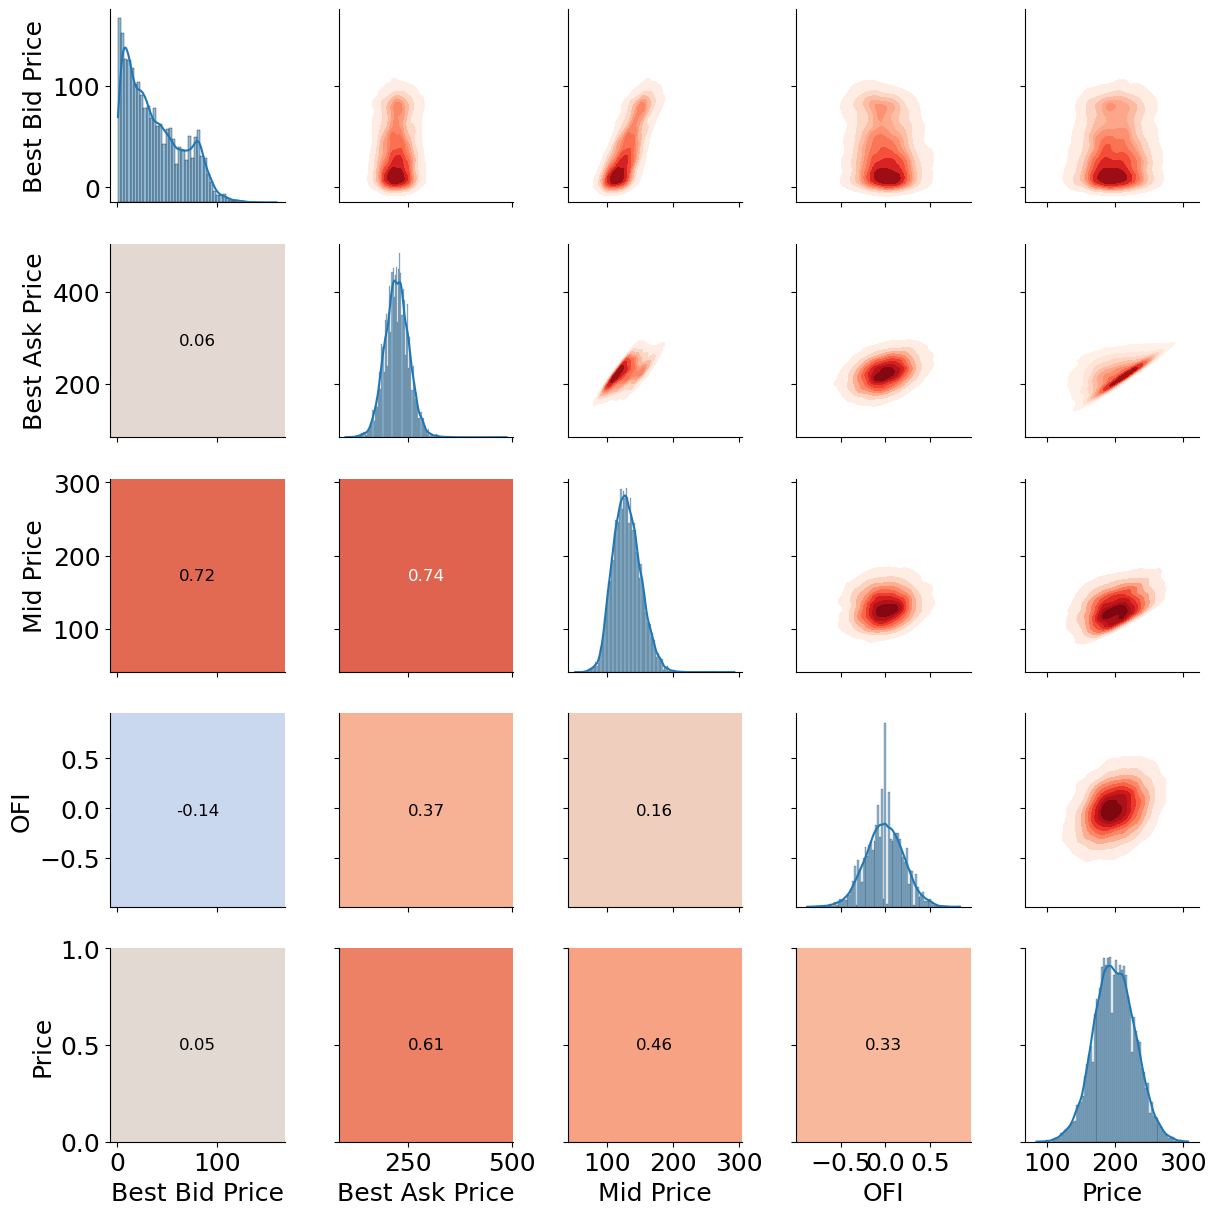

In [113]:

# 1. Sort both DataFrames by time
expanded_df.sort_values("Time", inplace=True)
tape_df.sort_values("Time", inplace=True)

# 2. Merge the DataFrames on the "Time" column (using a left join)
merged_df = pd.merge(
    expanded_df,
    tape_df[["Time", "Price"]],  # only bring over Time and Price
    on="Time",
    how="left"
)
cols_for_pairplot = [
    "Best Bid Price",
    "Best Ask Price",
    "Mid Price",
    "OFI",
    "Price"  # from tape_df
]
plot_df = merged_df[cols_for_pairplot]

import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def corrfunc(x, y, **kws):
    """Compute and plot the correlation coefficient in the lower-triangle cells,
       with background color determined by r."""
    # 1. Compute Pearson's r
    r = np.corrcoef(x, y)[0, 1]
    
    # 2. Grab the current axes, clear any existing plot
    ax = plt.gca()
    ax.clear()

    # 3. Create a color scale that maps r in [-1, +1] to some colormap
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.coolwarm  # or "RdBu", "bwr", etc.
    # Convert correlation coefficient to RGBA color
    bg_color = cmap(norm(r))
    # Set the entire cell background
    ax.set_facecolor(bg_color)

    # 4. Choose a text color (black or white) depending on how bright/dark the background is
    #    A simple heuristic: use luminance to pick black vs white text
    r_rgba = mcolors.to_rgba(bg_color)
    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]
    text_color = "white" if luminance < 0.5 else "black"

    # 5. Place the correlation coefficient text in the center
    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color=text_color)

# -- Main code --

# Suppose 'plot_df' has the numeric columns of interest (including 'Price' that sometimes has NaN).
# 1. Drop rows with NaNs in *any* of these columns:
df_no_na = plot_df.dropna()

# Alternatively, if you only want to drop rows missing a certain subset of columns,
# you can do: df_no_na = plot_df.dropna(subset=["Price", "OFI"])

# 2. Build the PairGrid using the cleaned DataFrame
g = sns.PairGrid(df_no_na, diag_sharey=False)

# 3. Lower triangle: correlation background
g.map_lower(corrfunc)

# 4. Upper triangle: e.g., red KDE plots
g.map_upper(sns.kdeplot, fill=True, cmap="Reds")

# 5. Diagonal: histograms with KDE
g.map_diag(sns.histplot, kde=True)

plt.tight_layout()
plt.show()


In [114]:
'''
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy import stats

def corrfunc(x, y, **kws):
    """Compute and plot the correlation coefficient in the lower-triangle cells,
       with background color determined by r."""
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.clear()

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.viridis
    bg_color = cmap(norm(r))
    ax.set_facecolor(bg_color)

    # Decide text color based on luminance
    r_rgba = mcolors.to_rgba(bg_color)
    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]
    text_color = "white" if luminance < 0.5 else "black"

    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color=text_color)

def density_scatter(x, y, **kwargs):
    """
    Plot a scatter of (x, y) where each point is colored by its local 2D density.
    We remove any 'color' kwarg that Seaborn might pass, so we can do c=z ourselves.
    """
    ax = plt.gca()
    # Drop any 'color' kwarg to avoid conflict with c=z
    if "color" in kwargs:
        kwargs.pop("color")

    # Convert x, y to NumPy arrays and drop NaNs
    x = np.array(x.dropna())
    y = np.array(y.dropna())

    if len(x) == 0 or len(y) == 0:
        return

    # Compute local density via Gaussian KDE
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    # Sort points by density
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Scatter with color = z
    ax.scatter(x, y, c=z, cmap="viridis", s=5, **kwargs)

# Suppose df_no_na is your DataFrame with no NaNs in columns of interest
g = sns.PairGrid(df_no_na, diag_sharey=False)

# Lower triangle: correlation cells
g.map_lower(corrfunc)

# Upper triangle: density scatter
g.map_upper(density_scatter)

# Diagonal: histograms with KDE
g.map_diag(sns.histplot, kde=True, color="black")

# Make sure every subplot has a box around it
for ax in g.axes.flatten():
    # Turn on all spines
    for spine in ax.spines.values():
        spine.set_visible(True)
    # Optionally, set a thicker linewidth for clarity
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)  # or another value


plt.tight_layout()
plt.show()
'''

'\nimport numpy as np\nimport seaborn as sns\nimport matplotlib.colors as mcolors\nimport matplotlib.pyplot as plt\nfrom scipy import stats\n\ndef corrfunc(x, y, **kws):\n    """Compute and plot the correlation coefficient in the lower-triangle cells,\n       with background color determined by r."""\n    r = np.corrcoef(x, y)[0, 1]\n    ax = plt.gca()\n    ax.clear()\n\n    norm = mcolors.Normalize(vmin=-1, vmax=1)\n    cmap = plt.cm.viridis\n    bg_color = cmap(norm(r))\n    ax.set_facecolor(bg_color)\n\n    # Decide text color based on luminance\n    r_rgba = mcolors.to_rgba(bg_color)\n    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]\n    text_color = "white" if luminance < 0.5 else "black"\n\n    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,\n                ha="center", va="center", fontsize=12, color=text_color)\n\ndef density_scatter(x, y, **kwargs):\n    """\n    Plot a scatter of (x, y) where each point is colored by its local 2D density.\

In [115]:
'''
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy import stats

def corrfunc(x, y, **kws):
    """Compute and plot the correlation coefficient in the lower-triangle cells,
       with background color determined by r."""
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.clear()

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.viridis
    bg_color = cmap(norm(r))
    ax.set_facecolor(bg_color)

    # Decide text color based on luminance
    r_rgba = mcolors.to_rgba(bg_color)
    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]
    text_color = "white" if luminance < 0.5 else "black"

    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color=text_color)

def density_scatter(x, y, **kwargs):
    """Scatter colored by local 2D density."""
    ax = plt.gca()
    if "color" in kwargs:
        kwargs.pop("color")

    x = np.array(x.dropna())
    y = np.array(y.dropna())
    if len(x) == 0 or len(y) == 0:
        return

    # Compute local density via Gaussian KDE
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    # Sort points by density
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, cmap="viridis", s=5, **kwargs)


# Example DataFrame: 'df_no_na' with numeric columns
g = sns.PairGrid(df_no_na, diag_sharey=False)

# Lower triangle: correlation cells
g.map_lower(corrfunc)

# Upper triangle: density scatter
g.map_upper(density_scatter)

# Diagonal: histograms with KDE
g.map_diag(sns.histplot, kde=True, color="black")

# ---------------------------------------------------------
# Force a full box around each subplot,
# but only show tick labels on the top row & rightmost column
# ---------------------------------------------------------
nrows, ncols = g.axes.shape  # e.g., 5x5 if you have 5 columns

for i in range(nrows):
    for j in range(ncols):
        ax = g.axes[i, j]
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', direction='out', length=5, width=1.5, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
        ax.tick_params(axis='both', which='minor', direction='out', length=2, width=1,
                    top=True, bottom=True, left=True, right=True)
        # 1) Make sure all spines (4 edges) are visible
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)  # or thicker if desired

        # 2) If we're in the top row, show X ticks on top
        if i == 0:
            ax.xaxis.set_ticks_position("top")
            ax.xaxis.set_label_position("top")
            ax.tick_params(labeltop=True, labelbottom=False)
        else:
            # hide x-axis labels for rows below top
            ax.tick_params(labeltop=False, labelbottom=False)

        # 3) If we're in the rightmost column, show Y ticks on the right
        if j == ncols - 1:
            ax.yaxis.set_ticks_position("right")
            ax.yaxis.set_label_position("right")
            ax.tick_params(labelright=True, labelleft=False)
        else:
            # hide y-axis labels for columns not on the right
            ax.tick_params(labelright=False, labelleft=False)

g.figure.set_size_inches(12, 12)

# 2) Use subplots_adjust to reduce wspace/hspace (gap between subplots)
#    and tighten up margins (left/right/top/bottom).
g.figure.subplots_adjust(
    wspace=0.01,  # horizontal space between subplots
    hspace=0.01,  # vertical space between subplots
    left=0.08,    # left margin
    right=0.8,   # right margin
    top=0.8,     # top margin
    bottom=0.08   # bottom margin
)

plt.tight_layout()
plt.show()
'''

'\nimport numpy as np\nimport seaborn as sns\nimport matplotlib.colors as mcolors\nimport matplotlib.pyplot as plt\nfrom scipy import stats\n\ndef corrfunc(x, y, **kws):\n    """Compute and plot the correlation coefficient in the lower-triangle cells,\n       with background color determined by r."""\n    r = np.corrcoef(x, y)[0, 1]\n    ax = plt.gca()\n    ax.clear()\n\n    norm = mcolors.Normalize(vmin=-1, vmax=1)\n    cmap = plt.cm.viridis\n    bg_color = cmap(norm(r))\n    ax.set_facecolor(bg_color)\n\n    # Decide text color based on luminance\n    r_rgba = mcolors.to_rgba(bg_color)\n    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]\n    text_color = "white" if luminance < 0.5 else "black"\n\n    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,\n                ha="center", va="center", fontsize=12, color=text_color)\n\ndef density_scatter(x, y, **kwargs):\n    """Scatter colored by local 2D density."""\n    ax = plt.gca()\n    if "color" in kwarg

In [116]:
'''
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy import stats

def corrfunc(x, y, **kws):
    """Compute and plot the correlation coefficient in the lower-triangle cells,
       with background color determined by r."""
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.clear()

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.viridis
    bg_color = cmap(norm(r))
    ax.set_facecolor(bg_color)

    # Decide text color based on luminance
    r_rgba = mcolors.to_rgba(bg_color)
    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]
    text_color = "white" if luminance < 0.5 else "black"

    ax.annotate(f"{r:.4f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color=text_color)

def density_scatter(x, y, **kwargs):
    """Scatter colored by local 2D density."""
    ax = plt.gca()
    if "color" in kwargs:
        kwargs.pop("color")

    x = np.array(x.dropna())
    y = np.array(y.dropna())
    if len(x) == 0 or len(y) == 0:
        return

    # Compute local density via Gaussian KDE
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    # Sort points by density so the densest points are on top
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, cmap="viridis", s=5, **kwargs)

'''


'\nimport numpy as np\nimport seaborn as sns\nimport matplotlib.colors as mcolors\nimport matplotlib.pyplot as plt\nfrom scipy import stats\n\ndef corrfunc(x, y, **kws):\n    """Compute and plot the correlation coefficient in the lower-triangle cells,\n       with background color determined by r."""\n    r = np.corrcoef(x, y)[0, 1]\n    ax = plt.gca()\n    ax.clear()\n\n    norm = mcolors.Normalize(vmin=-1, vmax=1)\n    cmap = plt.cm.viridis\n    bg_color = cmap(norm(r))\n    ax.set_facecolor(bg_color)\n\n    # Decide text color based on luminance\n    r_rgba = mcolors.to_rgba(bg_color)\n    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]\n    text_color = "white" if luminance < 0.5 else "black"\n\n    ax.annotate(f"{r:.4f}", xy=(0.5, 0.5), xycoords=ax.transAxes,\n                ha="center", va="center", fontsize=12, color=text_color)\n\ndef density_scatter(x, y, **kwargs):\n    """Scatter colored by local 2D density."""\n    ax = plt.gca()\n    if "color" in kwarg

In [117]:
'''
# Example PairGrid construction:
g = sns.PairGrid(df_no_na, diag_sharey=False)

# Lower triangle: correlation cells
g.map_lower(corrfunc)

# Upper triangle: density scatter
g.map_upper(density_scatter)

# Diagonal: histograms with KDE
g.map_diag(sns.histplot, kde=True, color="black")

# Now force each subplot to have all spines visible,
# and only show ticks/labels on top row & rightmost column
nrows, ncols = g.axes.shape

import matplotlib.ticker as mticker

for i in range(nrows):
    for j in range(ncols):
        ax = g.axes[i, j]

        # 1) Make all spines visible
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)

        # Hide all ticks/labels by default
        ax.tick_params(
            bottom=False, labelbottom=False,
            top=False,    labeltop=False,
            left=False,   labelleft=False,
            right=False,  labelright=False
        )

        # Show ticks/labels on the top row
        if i == 0:
            # Turn on major ticks for top edge
            ax.tick_params(top=True, labeltop=True)
            ax.tick_params(axis='x', which='major',
                           direction='out', length=10, width=1.5,
                           labelsize=12, top=True, bottom=False)

            # -- Enable minor ticks only on the x-axis --
            # 2) Set a minor locator specifically for x-axis
            ax.xaxis.set_minor_locator(mticker.AutoMinorLocator())

            # 3) Customize the minor ticks on x-axis
            ax.tick_params(axis='x', which='minor',
                           direction='out', length=5, width=1.0,
                           top=True, bottom=False)

            # 4) Disable minor ticks on y-axis by using a NullLocator
            ax.yaxis.set_minor_locator(mticker.NullLocator())

        # Show ticks/labels on the rightmost column
        if j == ncols - 1:
            ax.tick_params(right=True, labelright=True)
            ax.tick_params(axis='y', which='major',
                           direction='out', length=10, width=1.5,
                           labelsize=12, top=False, bottom=False)

            # Possibly do the same logic for minor ticks on the y-axis if you want them:
            ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
            ax.tick_params(axis='y', which='minor',
                           direction='out', length=5, width=1.0,
                           right=True, left=False)
            


# Optionally tweak figure size and spacing:
g.figure.set_size_inches(12, 12)
g.figure.subplots_adjust(
    wspace=0.03,
    hspace=0.03,
    left=0.07,
    right=0.97,
    top=0.95,
    bottom=0.07
)

plt.show()

'''


'\n# Example PairGrid construction:\ng = sns.PairGrid(df_no_na, diag_sharey=False)\n\n# Lower triangle: correlation cells\ng.map_lower(corrfunc)\n\n# Upper triangle: density scatter\ng.map_upper(density_scatter)\n\n# Diagonal: histograms with KDE\ng.map_diag(sns.histplot, kde=True, color="black")\n\n# Now force each subplot to have all spines visible,\n# and only show ticks/labels on top row & rightmost column\nnrows, ncols = g.axes.shape\n\nimport matplotlib.ticker as mticker\n\nfor i in range(nrows):\n    for j in range(ncols):\n        ax = g.axes[i, j]\n\n        # 1) Make all spines visible\n        for spine in ax.spines.values():\n            spine.set_visible(True)\n            spine.set_linewidth(1.5)\n\n        # Hide all ticks/labels by default\n        ax.tick_params(\n            bottom=False, labelbottom=False,\n            top=False,    labeltop=False,\n            left=False,   labelleft=False,\n            right=False,  labelright=False\n        )\n\n        # Show tic

----

In [118]:

'''
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, NullLocator
from scipy import stats

def corrfunc(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.clear()

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.viridis
    bg_color = cmap(norm(r))
    ax.set_facecolor(bg_color)

    # Decide text color based on luminance
    r_rgba = mcolors.to_rgba(bg_color)
    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]
    text_color = "white" if luminance < 0.5 else "black"

    ax.annotate(f"{r:.4f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color=text_color)

def density_scatter(x, y, **kwargs):
    ax = plt.gca()
    if "color" in kwargs:
        kwargs.pop("color")

    x = np.array(x.dropna())
    y = np.array(y.dropna())
    if len(x) == 0 or len(y) == 0:
        return

    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, cmap="viridis", s=5, **kwargs)

# Example PairGrid
g = sns.PairGrid(df_no_na, diag_sharey=False)

g.map_lower(corrfunc)
g.map_upper(density_scatter)
g.map_diag(sns.histplot, kde=True, color="black")

nrows, ncols = g.axes.shape

import matplotlib.ticker as ticker
from matplotlib.ticker import NullLocator, AutoMinorLocator

for i in range(nrows):
    for j in range(ncols):
        ax = g.axes[i, j]

        # Make spines thicker
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)

        # Disable all ticks by default
        ax.tick_params(
            which='both',
            bottom=False, labelbottom=False,
            top=False,    labeltop=False,
            left=False,   labelleft=False,
            right=False,  labelright=False
        )
        ax.xaxis.set_minor_locator(NullLocator())  # no minor ticks on x-axis by default
        ax.yaxis.set_minor_locator(NullLocator())  # no minor ticks on y-axis by default

        # If in top row => show major ticks on top, with minor ticks only on top
        if i == 0:
            # Major ticks on top row
            ax.tick_params(
                axis='x', which='major',
                top=True, labeltop=True,
                bottom=False,  # keep bottom off
                direction='in',
                length=8, width=1.5,
                labelsize=10
            )
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')

            # Use AutoMinorLocator only for the x-axis
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(
                axis='x', which='minor',
                top=True,
                bottom=False,
                direction='in',
                length=4, width=1
            )

        # If in rightmost column => show major ticks on right, with minor ticks only on right
        if j == ncols - 1:
            # Major ticks on right
            ax.tick_params(
                axis='y', which='major',
                right=True, labelright=True,
                left=False,  # keep left off
                direction='in',
                length=8, width=1.5,
                labelsize=10
            )
            # Use AutoMinorLocator only for the y-axis
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(
                axis='y', which='minor',
                right=True,
                left=False,
                direction='in',
                length=4, width=1
            )


g.figure.set_size_inches(12, 12)
g.figure.subplots_adjust(
    wspace=0.05,
    hspace=0.05,
    left=0.07,
    right=0.95,
    top=0.92,
    bottom=0.07
)



plt.show()
'''

'\nimport numpy as np\nimport seaborn as sns\nimport matplotlib.colors as mcolors\nimport matplotlib.pyplot as plt\nfrom matplotlib.ticker import AutoMinorLocator, NullLocator\nfrom scipy import stats\n\ndef corrfunc(x, y, **kws):\n    r = np.corrcoef(x, y)[0, 1]\n    ax = plt.gca()\n    ax.clear()\n\n    norm = mcolors.Normalize(vmin=-1, vmax=1)\n    cmap = plt.cm.viridis\n    bg_color = cmap(norm(r))\n    ax.set_facecolor(bg_color)\n\n    # Decide text color based on luminance\n    r_rgba = mcolors.to_rgba(bg_color)\n    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]\n    text_color = "white" if luminance < 0.5 else "black"\n\n    ax.annotate(f"{r:.4f}", xy=(0.5, 0.5), xycoords=ax.transAxes,\n                ha="center", va="center", fontsize=12, color=text_color)\n\ndef density_scatter(x, y, **kwargs):\n    ax = plt.gca()\n    if "color" in kwargs:\n        kwargs.pop("color")\n\n    x = np.array(x.dropna())\n    y = np.array(y.dropna())\n    if len(x) == 0 or le

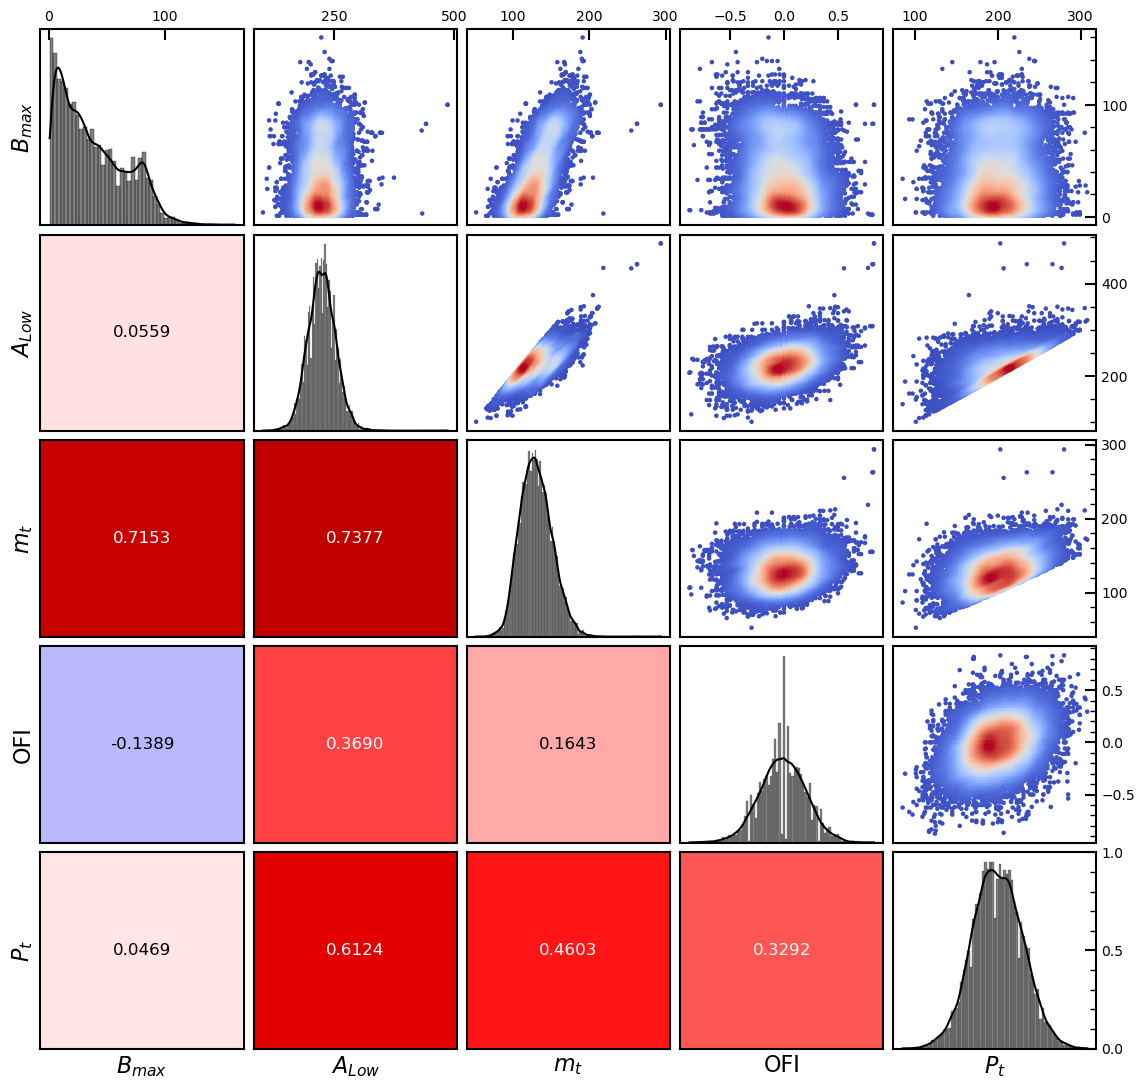

In [119]:
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, NullLocator
from scipy import stats

def corrfunc(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.clear()

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = plt.cm.seismic
    bg_color = cmap(norm(r))
    ax.set_facecolor(bg_color)

    # Decide text color based on luminance
    r_rgba = mcolors.to_rgba(bg_color)
    luminance = 0.2126*r_rgba[0] + 0.7152*r_rgba[1] + 0.0722*r_rgba[2]
    text_color = "white" if luminance < 0.5 else "black"

    ax.annotate(f"{r:.4f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha="center", va="center", fontsize=12, color=text_color)

def density_scatter(x, y, **kwargs):
    ax = plt.gca()
    if "color" in kwargs:
        kwargs.pop("color")

    x = np.array(x.dropna())
    y = np.array(y.dropna())
    if len(x) == 0 or len(y) == 0:
        return

    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, cmap="coolwarm", s=5, **kwargs)

# Example PairGrid
g = sns.PairGrid(df_no_na, diag_sharey=False)

g.map_lower(corrfunc)
g.map_upper(density_scatter)
g.map_diag(sns.histplot, kde=True, color="black")

nrows, ncols = g.axes.shape

import matplotlib.ticker as ticker
from matplotlib.ticker import NullLocator, AutoMinorLocator

for i in range(nrows):
    for j in range(ncols):
        ax = g.axes[i, j]

        # Make spines thicker
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)

        # Disable all ticks by default
        ax.tick_params(
            which='both',
            bottom=False, labelbottom=False,
            top=False,    labeltop=False,
            left=False,   labelleft=False,
            right=False,  labelright=False
        )
        ax.xaxis.set_minor_locator(NullLocator())  # no minor ticks on x-axis by default
        ax.yaxis.set_minor_locator(NullLocator())  # no minor ticks on y-axis by default

        # If in top row => show major ticks on top, with minor ticks only on top
        if i == 0:
            # Major ticks on top row
            ax.tick_params(
                axis='x', which='major',
                top=True, labeltop=True,
                bottom=False,  # keep bottom off
                direction='in',
                length=8, width=1.5,
                labelsize=10
            )
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')

            # Use AutoMinorLocator only for the x-axis
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(
                axis='x', which='minor',
                top=True,
                bottom=False,
                direction='in',
                length=4, width=1
            )

        # If in rightmost column => show major ticks on right, with minor ticks only on right
        if j == ncols - 1:
            # Major ticks on right
            ax.tick_params(
                axis='y', which='major',
                right=True, labelright=True,
                left=False,  # keep left off
                direction='in',
                length=8, width=1.5,
                labelsize=10
            )
            # Use AutoMinorLocator only for the y-axis
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(
                axis='y', which='minor',
                right=True,
                left=False,
                direction='in',
                length=4, width=1
            )


g.figure.set_size_inches(12, 12)
g.figure.subplots_adjust(
    wspace=0.05,
    hspace=0.05,
    left=0.07,
    right=0.95,
    top=0.92,
    bottom=0.07
)

# Suppose you've already created your PairGrid 'g' and mapped plots, e.g.:
# g = sns.PairGrid(df_no_na, ...)
# g.map_lower(...); g.map_upper(...); g.map_diag(...);

# Define a dictionary mapping each variable name to your custom label
label_map = {
    "Best Bid Price": "$B_{max}$",
    "Best Ask Price": "$A_{Low}$",
    "Mid Price": "$m_t$",
    "OFI": "OFI",
    "Price": "$P_t$"
    # Add more mappings as needed
}

# The bottom row is row index -1 in PairGrid, and the left column is col index 0.
# We'll loop over each variable index, rename only the bottom row x-label
# and the left column y-label.

# 1) Rename bottom row x-labels
for col_i, var_name in enumerate(g.x_vars):
    ax_bottom = g.axes[-1, col_i]  # bottom row, col_i-th subplot
    new_label = label_map.get(var_name, var_name)  # fallback to original if not in dict
    ax_bottom.set_xlabel(new_label, fontsize=16)
    # Re-enable bottom ticks if they were turned off

# 2) Rename left column y-labels
for row_i, var_name in enumerate(g.y_vars):
    ax_left = g.axes[row_i, 0]  # row_i-th subplot in left column
    new_label = label_map.get(var_name, var_name)
    ax_left.set_ylabel(new_label, fontsize=16)
    # Re-enable left ticks if they were turned off

plt.show()
